# LSTM Price Forecasting Pipeline
Dự báo giá 7 ngày tiếp theo với LSTM. Split: 80% Train / 20% Test

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Config
LOOKBACK = 30
FORECAST = 7
TRAIN_RATIO = 0.90
LSTM_UNITS, DROPOUT = 64, 0.2
EPOCHS, BATCH_SIZE, LR = 100, 32, 0.001
DATA_PATH = r'd:\ProjectML\DATACRAWED\ETHUSDT.csv'
EPS = 1e-8

In [ ]:
# Load Data
df = pd.read_csv(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
print(f'Data: {len(df)} rows | {df["Date"].min().date()} to {df["Date"].max().date()}')
df.tail()

Data: 2227 rows | 2019-11-27 to 2025-12-31


,Date,Open,High,Low,Close,Volume
2222,2025-12-27,2926.83,2959.84,2914.63,2947.61,899512.695
2223,2025-12-28,2947.61,2959.99,2922.84,2949.60,1156340.657
2224,2025-12-29,2949.60,3056.00,2908.58,2936.45,4975460.686
2225,2025-12-30,2936.45,3008.67,2917.48,2972.22,3160478.075
2226,2025-12-31,2972.23,3027.73,2957.59,2970.40,2411514.797


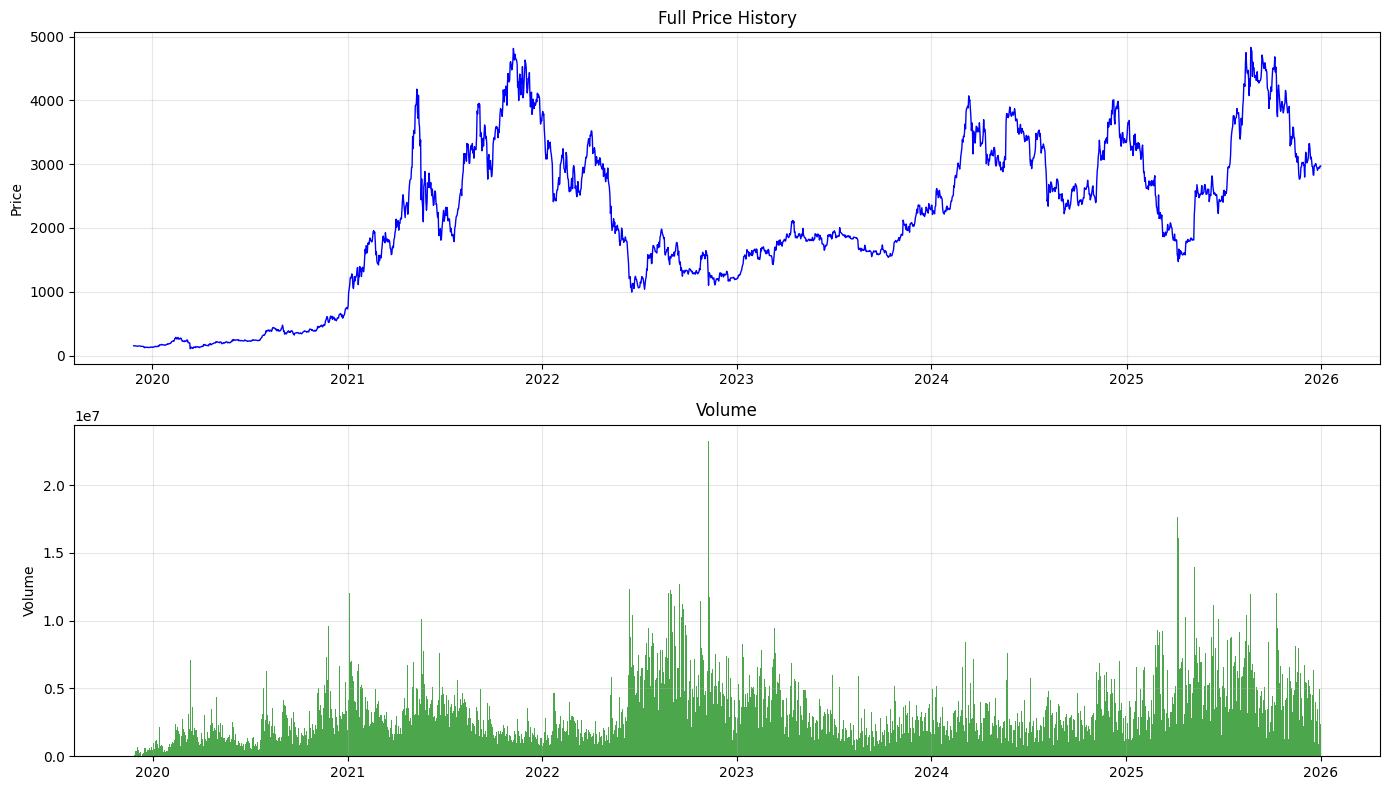

In [ ]:
# Plot Full Timeseries
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(df['Date'], df['Close'], lw=1, color='blue')
axes[0].set_title('Full Price History')
axes[0].set_ylabel('Price')
axes[0].grid(alpha=0.3)
axes[1].bar(df['Date'], df['Volume'], width=1, color='green', alpha=0.7)
axes[1].set_title('Volume')
axes[1].set_ylabel('Volume')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering: VVR, VWAP, Lag Features
df['VVR'] = df['Volume'] / (df['High'] - df['Low'] + EPS)
df['VWAP'] = ((df['High']+df['Low']+df['Close'])/3 * df['Volume']).cumsum() / df['Volume'].cumsum()
for lag in [1,2,3,5,7]: df[f'Lag_{lag}'] = df['Close'].shift(lag)
df['Change'] = df['Close'].pct_change()
df['Volatility'] = df['High'] - df['Low']
df['MA5'] = df['Close'].rolling(5).mean()
df['MA10'] = df['Close'].rolling(10).mean()
df = df.dropna().reset_index(drop=True)
print(f'Features: {df.shape[1]-1} | Rows: {len(df)}')

Features: 16 | Rows: 2218


In [ ]:
# Preprocessing: Scale + Sequences
feature_cols = [c for c in df.columns if c != 'Date']
target_idx = feature_cols.index('Close')
dates = df['Date'].values

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols].values)
target_scaler = MinMaxScaler()
target_scaler.fit(df['Close'].values.reshape(-1,1))

X, y = [], []
for i in range(LOOKBACK, len(scaled)-FORECAST+1):
    X.append(scaled[i-LOOKBACK:i])
    y.append(scaled[i:i+FORECAST, target_idx])
X, y = np.array(X), np.array(y)
print(f'X: {X.shape} | y: {y.shape}')

X: (2182, 30, 16) | y: (2182, 7)


In [ ]:
# Split: 80% Train / 20% Test (No Shuffle)
n = len(X)
split_idx = int(n * TRAIN_RATIO)
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]
seq_dates = dates[LOOKBACK:len(dates)-FORECAST+1]
train_dates, test_dates = seq_dates[:split_idx], seq_dates[split_idx:]
print(f'Train: {len(X_train)} | Test: {len(X_test)}')

Train: 1963 | Test: 219


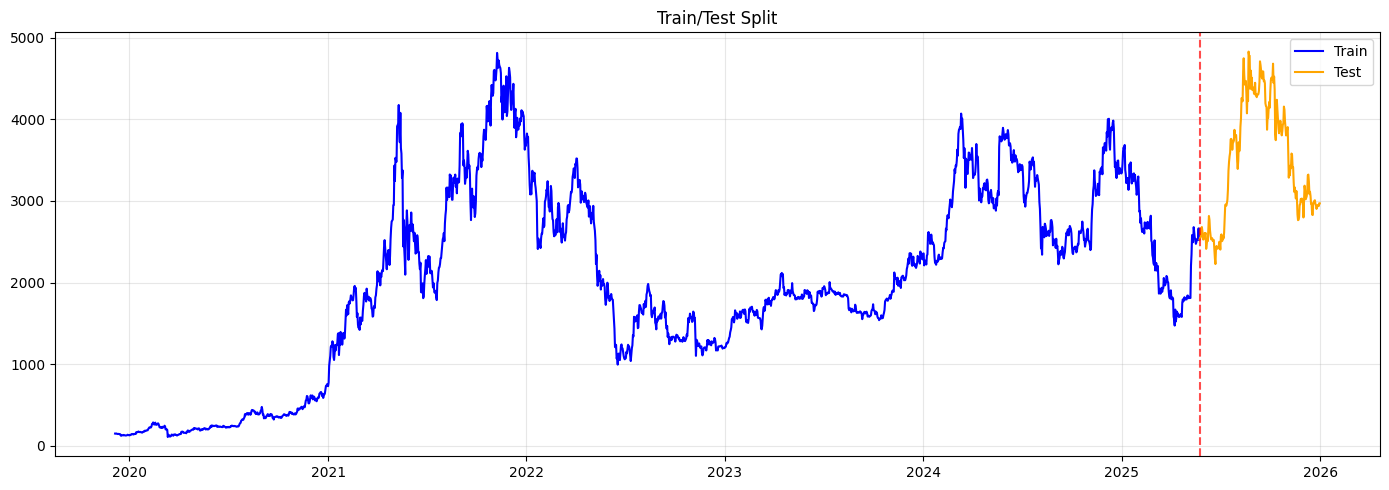

In [ ]:
# Plot Train/Test Split
plt.figure(figsize=(14, 5))
split_date_idx = int(len(df) * TRAIN_RATIO)
plt.plot(df['Date'][:split_date_idx], df['Close'][:split_date_idx], label='Train', lw=1.5, color='blue')
plt.plot(df['Date'][split_date_idx:], df['Close'][split_date_idx:], label='Test', lw=1.5, color='orange')
plt.axvline(df['Date'].iloc[split_date_idx], color='red', linestyle='--', alpha=0.7)
plt.title('Train/Test Split')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Build Stacked LSTM (2 layers, 64 units, Dropout 0.2)
model = Sequential([
    LSTM(LSTM_UNITS, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(DROPOUT),
    LSTM(LSTM_UNITS, return_sequences=False),
    Dropout(DROPOUT),
    Dense(FORECAST)
])
model.compile(optimizer=Adam(learning_rate=LR), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 30, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,215 (211.78 KB)

 Trainable params: 54,215 (211.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train with Early Stopping
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    callbacks=[es], verbose=1)
print(f'Stopped at epoch {len(history.history["loss"])}')

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0219 - mae: 0.0994
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0086 - mae: 0.0664
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0632
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064 - mae: 0.0573
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - mae: 0.0566
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - mae: 0.0504
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - mae: 0.0510
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - mae: 0.0488
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - mae: 0.0469
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - mae: 0.0470
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - mae: 0.0449
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - mae: 0.0434
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━

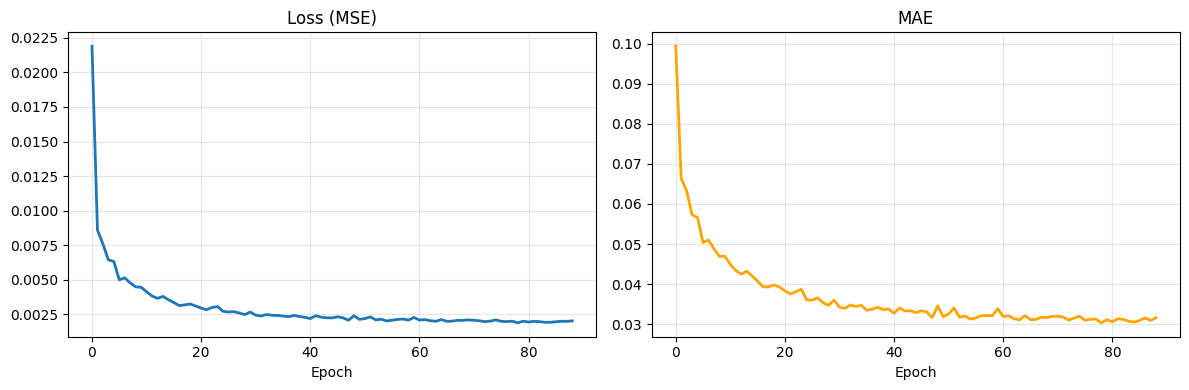

In [ ]:
# Plot Training History
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['loss'], lw=2)
axes[0].set_title('Loss (MSE)')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)
axes[1].plot(history.history['mae'], lw=2, color='orange')
axes[1].set_title('MAE')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on Test (Inverse Transform)
y_pred = target_scaler.inverse_transform(model.predict(X_test))
y_true = target_scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f'RMSE: {rmse:.4f} | MAE: {mae:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
RMSE: 319.3389 | MAE: 250.6748


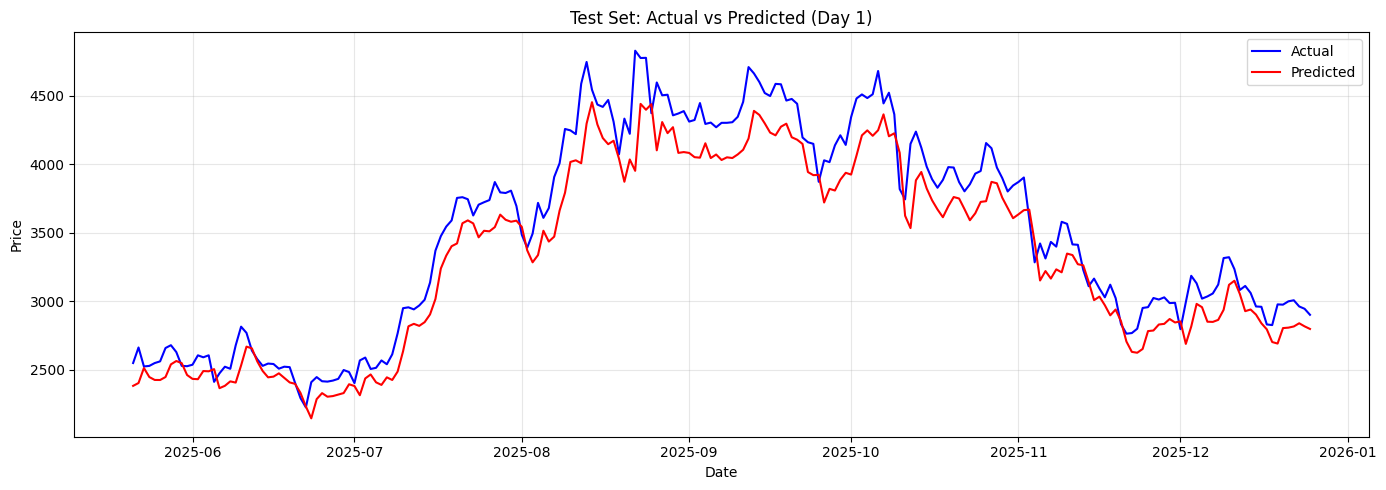

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(14, 5))
plt.plot(pd.to_datetime(test_dates), y_true[:,0], label='Actual', lw=1.5, color='blue')
plt.plot(pd.to_datetime(test_dates), y_pred[:,0], label='Predicted', lw=1.5, color='red')
plt.title('Test Set: Actual vs Predicted (Day 1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

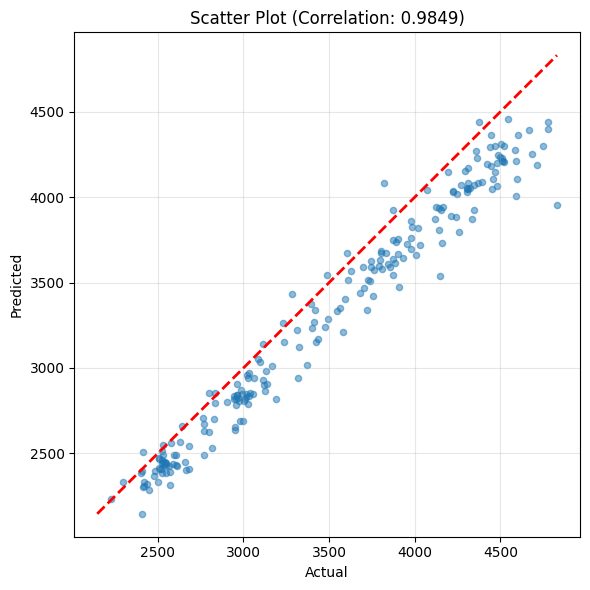

In [ ]:
# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_true[:,0], y_pred[:,0], alpha=0.5, s=20)
min_v, max_v = min(y_true[:,0].min(), y_pred[:,0].min()), max(y_true[:,0].max(), y_pred[:,0].max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Scatter Plot (Correlation: {np.corrcoef(y_true[:,0], y_pred[:,0])[0,1]:.4f})')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

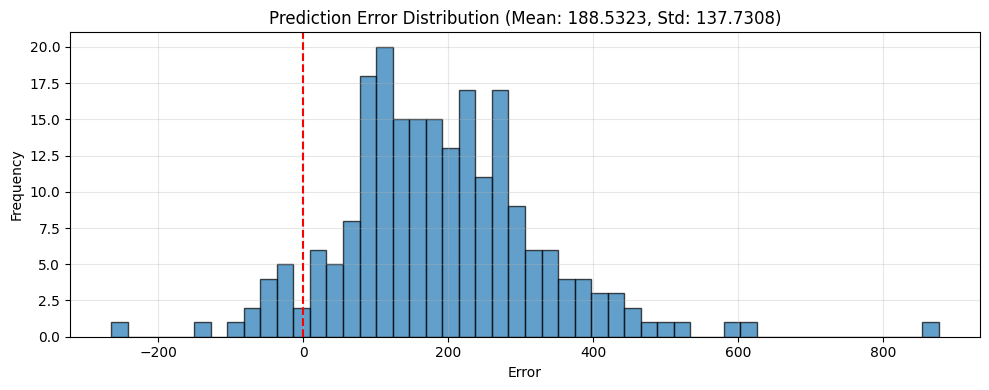

In [ ]:
# Error Distribution
errors = y_true[:,0] - y_pred[:,0]
plt.figure(figsize=(10, 4))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title(f'Prediction Error Distribution (Mean: {errors.mean():.4f}, Std: {errors.std():.4f})')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Forecast Next 7 Days
last_seq = scaled[-LOOKBACK:].reshape(1, LOOKBACK, -1)
forecast = target_scaler.inverse_transform(model.predict(last_seq))[0]
last_date = pd.to_datetime(df['Date'].iloc[-1])
forecast_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=FORECAST)

print('7-Day Forecast:')
for i, (d, p) in enumerate(zip(forecast_dates, forecast), 1):
    print(f'  Day {i} ({d.strftime("%Y-%m-%d")}): ${p:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7-Day Forecast:
  Day 1 (2026-01-01): $2822.0403
  Day 2 (2026-01-02): $2825.0481
  Day 3 (2026-01-03): $2822.4956
  Day 4 (2026-01-04): $2826.0457
  Day 5 (2026-01-05): $2798.1675
  Day 6 (2026-01-06): $2824.4521
  Day 7 (2026-01-07): $2819.6890


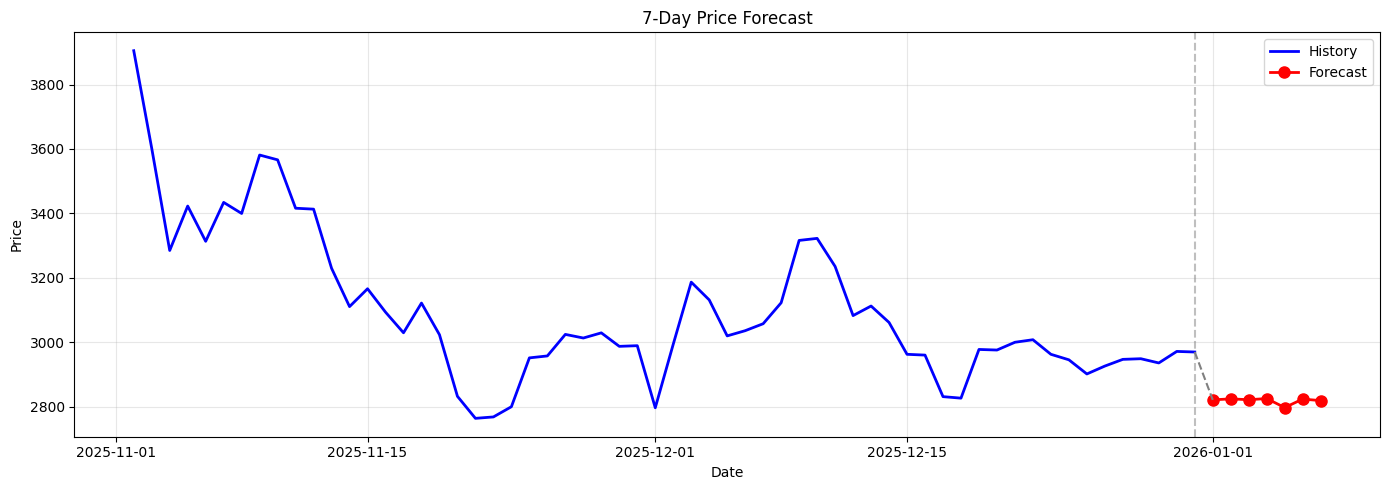

In [ ]:
# Plot Forecast with History
plt.figure(figsize=(14, 5))
n_hist = 60
plt.plot(df['Date'].iloc[-n_hist:], df['Close'].iloc[-n_hist:], label='History', lw=2, color='blue')
plt.plot(forecast_dates, forecast, label='Forecast', lw=2, color='red', marker='o', markersize=8)
plt.plot([df['Date'].iloc[-1], forecast_dates[0]], [df['Close'].iloc[-1], forecast[0]], '--', color='gray')
plt.axvline(df['Date'].iloc[-1], color='gray', linestyle='--', alpha=0.5)
plt.title('7-Day Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()